# Raster Extration 

- to points
- to lines
- to polygons

uses `rasterstats`

In [75]:
import matplotlib.pyplot as plt 
import rasterstats
import rasterio.plot
import geopandas as gpd 
import numpy as np

In [76]:
from helpers import zion, zion_points, src_srtm

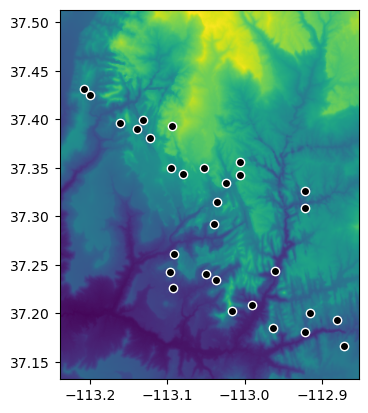

In [77]:
fig, ax = plt.subplots() 
rasterio.plot.show(src_srtm, ax=ax)
zion_points.plot(ax=ax, color='k', ec='w');

## Extraction to points

In [78]:
result1 = rasterstats.point_query(
    zion_points, 
    src_srtm.read(1), 
    nodata = src_srtm.nodata, 
    affine = src_srtm.transform, 
    interpolate = 'nearest'
)

>Pass the file directly seems simpler

In [79]:
result2 = rasterstats.point_query(
    zion_points, 
    '../data/srtm.tif', 
    interpolate='nearest'
)

In [80]:
result1[:5]

[1802, 2433, 1886, 1370, 1452]

In [81]:
zion_points['elev1'] = result1
zion_points['elev2'] = result2
zion_points[::5]

,geometry,elev1,elev2
0,POINT (-112.91587 37.20013),1802,1802
5,POINT (-112.88066 37.19319),1635,1635
10,POINT (-112.92196 37.18084),1440,1440
15,POINT (-113.05301 37.34973),2198,2198
20,POINT (-113.00615 37.35577),2159,2159
25,POINT (-113.13187 37.39955),2102,2102


## Extraction to lines

>It is hard to calculate values for long lines that cross raster cells. They can be resampled into points of an arbitrary distanced, assigned value, and then reconstituted.
>
>The example is calculating elevation on a straight line in zion park.

In [82]:
import shapely

In [83]:
coords = [[-113.2, 37.45], [-112.9, 37.2]]
zion_transect = shapely.LineString(coords)
print(zion_transect)

LINESTRING (-113.2 37.45, -112.9 37.2)


>Create points at every 250m along the line

In [84]:
zion_transect_utm = gpd.GeoSeries(zion_transect, crs=4326).to_crs(32612)

In [85]:
zion_transect_utm = zion_transect_utm.iloc[0]

In [86]:
print(zion_transect_utm)

LINESTRING (305399.67208180577 4147066.650206682, 331380.8917453843 4118750.0947884847)


In [87]:
distances = np.arange(0, zion_transect_utm.length, 250)
distances[::20]

array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.])

In [88]:
zion_transect_pnt = [zion_transect_utm.interpolate(d)
                     for d in distances]
zion_transect_pnt = (gpd.GeoSeries(zion_transect_pnt, crs=32612)
                    .to_crs(src_srtm.crs))
zion_transect_pnt

0             POINT (-113.2 37.45)
1      POINT (-113.19804 37.44838)
2      POINT (-113.19608 37.44675)
3      POINT (-113.19413 37.44513)
4      POINT (-113.19217 37.44351)
                  ...             
149    POINT (-112.90918 37.20769)
150    POINT (-112.90724 37.20606)
151    POINT (-112.90529 37.20443)
152     POINT (-112.90334 37.2028)
153     POINT (-112.9014 37.20117)
Length: 154, dtype: geometry

In [89]:
result = rasterstats.point_query(
    zion_transect_pnt, 
    src_srtm.read(1), 
    nodata= src_srtm.nodata, 
    affine = src_srtm.transform, 
    interpolate='nearest'
)
zion_transect_pnt = gpd.GeoDataFrame(geometry=zion_transect_pnt)
zion_transect_pnt['dist'] = distances
zion_transect_pnt['elev'] = result
print(zion_transect_pnt)

                        geometry     dist  elev
0           POINT (-113.2 37.45)      0.0  2001
1    POINT (-113.19804 37.44838)    250.0  2037
2    POINT (-113.19608 37.44675)    500.0  1949
3    POINT (-113.19413 37.44513)    750.0  1869
4    POINT (-113.19217 37.44351)   1000.0  1783
..                           ...      ...   ...
149  POINT (-112.90918 37.20769)  37250.0  1854
150  POINT (-112.90724 37.20606)  37500.0  1897
151  POINT (-112.90529 37.20443)  37750.0  1837
152   POINT (-112.90334 37.2028)  38000.0  1841
153   POINT (-112.9014 37.20117)  38250.0  1819

[154 rows x 3 columns]


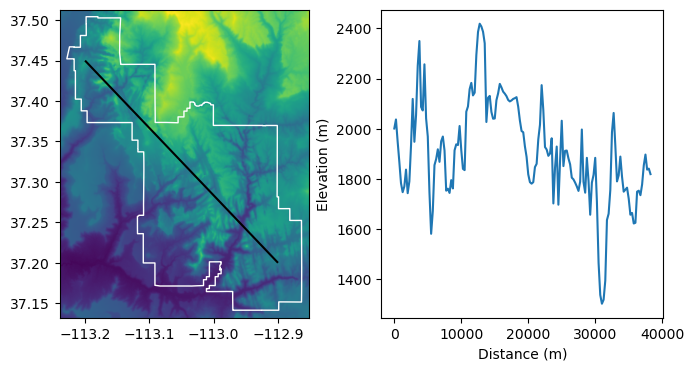

In [107]:
# Raster and a line transect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
rasterio.plot.show(src_srtm, ax=ax1)
gpd.GeoSeries(zion_transect).plot(ax=ax1, color='black')
zion.to_crs(src_srtm.crs).plot(ax=ax1, color='none', ec='w')
zion_transect_pnt.set_index('dist')['elev'].plot(ax=ax2)
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('Elevation (m)');

# Extraction to polygons

>Typically used to generate summary statistics per region

In [109]:
zion = zion.to_crs(src_srtm.crs)

>Continuous values

In [110]:
result = rasterstats.zonal_stats(
    zion, 
    src_srtm.read(1), 
    nodata = src_srtm.nodata, 
    affine = src_srtm.transform, 
    stats = ['mean', 'min', 'max']
)
result

[{'min': 1122.0, 'max': 2661.0, 'mean': 1818.211830154405}]

In [111]:
import pandas as pd

In [112]:
pd.DataFrame(result)

,min,max,mean
0,1122.0,2661.0,1818.21183


Only one result because only one polygon in zion

>Categorical values

In [113]:
import rasterio.mask

In [114]:
from helpers import src_nlcd

In [115]:
out_image, out_transform = rasterio.mask.mask(
    src_nlcd, 
    zion.geometry.to_crs(src_nlcd.crs), 
    crop=False, 
    nodata=src_nlcd.nodata
)
counts = np.unique(out_image, return_counts=True)
counts

(array([  2,   3,   4,   5,   6,   7,   8, 255], dtype=uint8),
 array([  4205,  98285, 298299, 203701,    235,     62,    679, 852741]))

>In the example, `2` represents 'Developed' and it appears in 4205 pixels within the Zion polygon

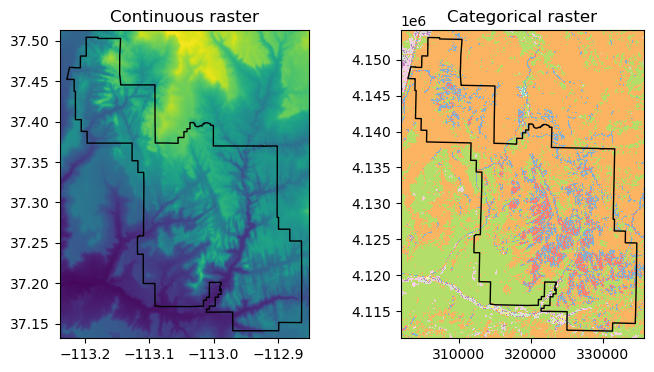

In [121]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
rasterio.plot.show(src_srtm, ax=ax1)
zion.plot(ax=ax1, color='none', ec='k')
rasterio.plot.show(src_nlcd, ax=ax2, cmap='Set3')
zion.to_crs(src_nlcd.crs).plot(ax=ax2, color='none', ec='k')
ax1.set_title("Continuous raster")
ax2.set_title("Categorical raster");